# 2016 TTS Survey Data - Segmentation

## Background and Data

In this notebook, we begin thinking about labelling the entries in the TTS survey data into segments, as was done for SMTO data. Note that this file uses the filtered dataset, where we have attempted to remove entries with missing information and those who are not post-secondary students.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../Data/TTS_2016/Filtered.csv')
df.head()

,Unnamed: 0,HomeZone,SchoolZone,SchoolCode,Age,Sex,License,Occupation,EmploymentStatus,StudentStatus,Vehicles,IncomeClass,Adults,Children,ExpansionFactor,ModeTakenToSchool,TripToSchoolTime,Dist
0,1,264,25,9244,19,M,N,O,O,S,2,3,5,0,42.03,B,1300,5.801714
1,2,38,25,9243,22,M,Y,S,P,S,0,3,2,0,21.01,W,1000,1.529490
2,3,1039,25,9244,26,M,Y,O,O,S,3,7,5,1,16.17,D,700,32.200970
3,4,613,25,9244,19,M,Y,O,O,S,1,2,4,0,44.06,B,645,23.502050
4,7,2053,25,9244,31,F,Y,G,F,P,1,7,2,0,12.52,9,-1,32.690450


Now, we are going to use this data to segment the respondents into the 13 categories. The labels used for each segment are listed in the table below:

| Level | Full Time | | Part Time | |
| --- | --- | --- | --- | --- |
| | Family | Not | Family | Not |
| First-year UG | 1 | 2 | 3 | 4 |
| Upper-year UG | 5 | 6 | 7 | 8 |
| Grad | 9 | 10 | 11 | 12 |
| Other | 0 | 0 | 0 | 0 |

To guide our segmentation, we will refer to the patterns from SMTO data.

In [3]:
SMTO_df = pd.read_csv('../../Data/SMTO_2015/Formatted.csv')
SMTO_df.head()

,Campus,Level,Status,Mode_Actual,Gender,Licence,Work,Age,HomeZone,Family,...,Closest.OC,Closest.RY,Closest.SC,Closest.SG,Closest.YG,Closest.YK,Time.Active,Time.Auto,Time.Transit,Exp_Factor
0,Scarborough (UTSC),UG,FT,Transit Bus,Female,0,Unknown,20,261,1,...,0,0,0,0,1,0,223.214700,17.474220,75.468478,[1.180745526182362]
1,Downtown Toronto (St. George),Grad,FT,Walk,Female,1,Unknown,25,71,0,...,0,0,0,1,0,0,16.985265,2.924953,24.128386,[0.7276973429613323]
2,Downtown Toronto (St. George),UG,FT,Transit Bus,Female,1,Unknown,23,3714,1,...,0,0,0,0,0,0,495.534450,67.715080,124.643180,[0.7276973429613323]
3,Downtown Toronto (St. George),UG,FT,Walk,Male,1,Unknown,20,74,0,...,0,0,0,1,0,0,10.491210,1.049121,16.675728,[0.7276973429613323]
4,Downtown Toronto (St. George),Grad,FT,Walk,Male,1,Unknown,27,71,0,...,0,0,0,1,0,0,16.985265,2.924953,24.128386,[0.7276973429613323]


## Predicting Living Arrangment

Let's attempt to estalish whether a student is living with their family.

### Household Composition

We assume any student whose household does not include any adults, except, possibly for the student themselves, are not living with their parents/family.

In [4]:
df['NoOtherAdults'] = ((df['Age'] >= 18) & (df['Adults'] == 1)) | ((df['Age'] < 18) & (df['Adults'] == 0))
df['NoOtherAdults'].value_counts()

False    14121
True      1028
Name: NoOtherAdults, dtype: int64

For students with other adults in the household thing are trickier. We need to identify whether the other adults are the students' parents/family or roommates/partner.

First let's look only at students 18 or older. From the SMTO data, we can check how many of those who have children under 18 in the household are listed as living with family.

In [5]:
temp = SMTO_df[(SMTO_df['Age'] >= 18) & (SMTO_df['Children'] >= 1)]
temp['Family'].value_counts(normalize=True)

1    0.871589
0    0.128411
Name: Family, dtype: float64

It seems that most students are 18 or over but have children under 18 in the household are living with family/parents, but not all. Perhaps seeing the number of adults for those who are vs. those who aren't can help.

In [6]:
print("# Adults\t% Family")
for numAdults in set(temp['Adults']):
    total = len(temp[temp['Adults'] == numAdults])
    print(str(numAdults) + "\t\t", len(temp[(temp['Family'] == 1) & (temp['Adults'] == numAdults)]) / total)

# Adults	% Family
1		 0.3673469387755102
2		 0.6045016077170418
3		 0.9610999329309189
4		 0.9634146341463414
5		 0.9235880398671097
6		 0.9
7		 0.8604651162790697
8		 0.6923076923076923
9		 0.3333333333333333
10		 0.3333333333333333
11		 0.2
14		 0.0
15		 0.0


This shows mixed results for those with 1 or 2 adults in their household. For respondents with 3-8 adults in the household, the respondent was usually living with their family. For respondents with more than 8 adults, the respondents were usually not living with their family.

Let's perform a similar check for number of children in the household.

In [7]:
print("# Children\t% Family")
for numChildren in set(temp['Children']):
    total = len(temp[temp['Children'] == numChildren])
    print(str(numChildren) + "\t\t", len(temp[(temp['Family'] == 1) & (temp['Children'] == numChildren)]) / total)

# Children	% Family
1		 0.8746887966804979
2		 0.866421568627451
3		 0.8391959798994975
4		 0.9534883720930233
5		 0.8888888888888888
6		 1.0
7		 1.0
18		 0.0


For every number of children less than 8, students were very likely to be living with their family (especially for 4 or more children.

It seems that household composition can be a very good indicator for whether a student is living with their family or not, in certain conditions.

### Household Income

Let's see whether income level can help predict living arrangement. Unfortunately, the income ranges used by SMTO and TTS are different. Therefore, only if this seems to be an excellent predictor of living arrangement should income range be considered.

Here are the income levels reported:

In [8]:
SMTO_df['Income'].value_counts()

Unknown    8745
Low        4338
High       1570
Name: Income, dtype: int64

In [9]:
print("Income\t % Family")
for income in set(SMTO_df['Income']):
    total = len(SMTO_df[SMTO_df['Income'] == income])
    print(income + "\t", len(SMTO_df[(SMTO_df['Family'] == 1) & (SMTO_df['Income'] == income)]) / total)

Income	 % Family
Unknown	 0.5997712978845054
High	 0.6554140127388535
Low	 0.47325956662056246


For the most part, income level is not a strong predictor of whether a students lives with their family or not. The income level with the greatest variation from the sample mean is the lowest one - students whose household income level was less than #30,000 were much less likely to be living with their family, at 34%. This is not surprising, since students living with their family  would include their family members' income in the household income.
However, even this income level is not a reliable indicator of whether a student is living away from their family. Perhaps it will be a stronger indicator in combination with enrolment status.

In [10]:
temp_df = SMTO_df[SMTO_df['Income'] == 'Low']

print(temp_df['Status'].value_counts(normalize=True))
print()
print(SMTO_df['Status'].value_counts(normalize=True))

FT    0.932227
PT    0.067773
Name: Status, dtype: float64

FT    0.927523
PT    0.072477
Name: Status, dtype: float64


Important to note is that the distribution by enrolment status of students in the lowest household income level is similar to that of the entire sample.

In [11]:
print("For the lowest income range:")
print("Status\t% Family")
for status in set(temp_df['Status']):
    total = len(temp_df[temp_df['Status'] == status])
    print(status + "\t", len(temp_df[(temp_df['Family'] == 1) & (temp_df['Status'] == status)]) / total)

print("\nFor the entire data set:")
print("Status\t% Family")
for status in set(SMTO_df['Status']):
    total = len(SMTO_df[SMTO_df['Status'] == status])
    print(status + "\t", len(SMTO_df[(SMTO_df['Family'] == 1) & (SMTO_df['Status'] == status)]) / total)

For the lowest income range:
Status	% Family
FT	 0.4794757665677547
PT	 0.3877551020408163

For the entire data set:
Status	% Family
FT	 0.5764108601280259
PT	 0.4642184557438795


As we can see, enrolment status is not a good indicator for a students' living arrangements for students in this particular range or for the sample as a whole.

In conclusion, it does not seem that household income level is not a very useful predictor of students' living arrangements in isolation.

### Vehicle Information

Here we check how vehicle and licence ownership are correlated with living arrangement. First, let's see how the number of cars owned can help predict whether a student is living with their family/parents:

In [12]:
car_nums = set(SMTO_df['Cars'])
for i in car_nums:
    print("% of students with " + str(i) + " cars who live with Family/Parents:", end=' ')
    car_percent = ((SMTO_df['Cars'] == i) & (SMTO_df['Family'] == 1)).sum()/(SMTO_df['Cars'] == i).sum()
    print(car_percent)

% of students with 0 cars who live with Family/Parents: 0.14245187436676798
% of students with 1 cars who live with Family/Parents: 0.6631578947368421
% of students with 2 cars who live with Family/Parents: 0.8796769851951548
% of students with 3 cars who live with Family/Parents: 0.9233511586452763
% of students with 4 cars who live with Family/Parents: 0.9212598425196851
% of students with 5 cars who live with Family/Parents: 0.9245283018867925
% of students with 6 cars who live with Family/Parents: 1.0
% of students with 7 cars who live with Family/Parents: 1.0
% of students with 8 cars who live with Family/Parents: 1.0
% of students with 9 cars who live with Family/Parents: 0.5


The more cars a person has, the more likely they are living with their families. Students with 2 or more cars are probably living at home, while students who do not own any cars are most likely living without their families. 

Now let's look at licence ownership:

In [13]:
SMTO_df['Licence'].value_counts()

1    8796
0    5857
Name: Licence, dtype: int64

In [14]:
licence = set(SMTO_df['Licence'])
for i in licence:
    if i == 0:
        temp = 'TRUE'
    else:
        temp = 'FALSE'
    print("% of students with Driving_Licence = " + temp + " who live with Family/Parents:", end=' ')
    licence_percent = ((SMTO_df['Licence'] == i) & (SMTO_df['Family'] == 1)).sum()/(SMTO_df['Licence'] == i).sum()
    print(licence_percent)

% of students with Driving_Licence = TRUE who live with Family/Parents: 0.6158442888850948
% of students with Driving_Licence = FALSE who live with Family/Parents: 0.5366075488858572


Drivers' licence ownership in isolation does not accurately predict living with family.

It would make sense that most students that does not have a drivers' licence but whose household owns at least one car are libing with their family/parents. Let us check if this is true:

In [15]:
print('% of students that own at least a car, do not have a licence, and live at home:')
print(((SMTO_df['Cars'] > 0) & (SMTO_df['Family'] == 1) & (SMTO_df['Licence'] == 0)).sum()/((SMTO_df['Cars'] > 0) & (SMTO_df['Licence'] == 0)).sum())

% of students that own at least a car, do not have a licence, and live at home:
0.8877020785219399


Indeed, students that own at least one car but who do not have a licence are most likely living at home.

Finally, let us see if enrolment status (full-time vs. part-time) in conjunction with vehicle ownership better predicts living arrangement.

In [16]:
print('% of Full-time students who own at least one car and live at home:')
print(((SMTO_df['Cars'] > 0) & (SMTO_df['Family'] == 1) & (SMTO_df['Status'] == 'FT')).sum()/((SMTO_df['Cars'] > 0) & (SMTO_df['Status'] == 'FT')).sum())
print()
print('% of Part-time students who own at least one car and live at home:')
print(((SMTO_df['Cars'] > 0) & (SMTO_df['Family'] == 1) & (SMTO_df['Status'] == 'PT')).sum()/((SMTO_df['Cars'] > 0) & (SMTO_df['Status'] == 'PT')).sum())

% of Full-time students who own at least one car and live at home:
0.8039347194276771

% of Part-time students who own at least one car and live at home:
0.5595854922279793


Full-time students who own at least one car are a lot more likely to live with their families than part-time students that own at least one car. This might be connected to the students' socioeconomic status, or simply that full-time students are more likely to be living at home.

## Predicting Level of Study

We must also label students based on whether they are first-year undergrads, upper-year undergrads, grads, or other.

### Age

Age is the most obvious factor which can be used to predict level of study. Let us see the proportion of students who are first-year undergrad from each age.

Most 17 and 18 year-olds are indeed in their First-year of Undergrad education. We can see that there are various outliers in both ends of the age range.

Now let's check upper-year undergrads:

Percentage of 0 year-olds in Other Undergrad: 1.0
Percentage of 2 year-olds in Other Undergrad: 1.0
Percentage of 3 year-olds in Other Undergrad: 1.0
Percentage of 4 year-olds in Other Undergrad: 0.0
Percentage of 5 year-olds in Other Undergrad: 0.0
Percentage of 15 year-olds in Other Undergrad: 1.0
Percentage of 16 year-olds in Other Undergrad: 1.0
Percentage of 17 year-olds in Other Undergrad: 1.0
Percentage of 18 year-olds in Other Undergrad: 0.99795605518651
Percentage of 19 year-olds in Other Undergrad: 0.9994314951677089
Percentage of 20 year-olds in Other Undergrad: 0.979948586118252
Percentage of 21 year-olds in Other Undergrad: 0.9552319309600863
Percentage of 22 year-olds in Other Undergrad: 0.7913561847988078
Percentage of 23 year-olds in Other Undergrad: 0.5969664138678223
Percentage of 24 year-olds in Other Undergrad: 0.5156037991858887
Percentage of 25 year-olds in Other Undergrad: 0.442572741194487
Percentage of 26 year-olds in Other Undergrad: 0.42714570858283435
Percen

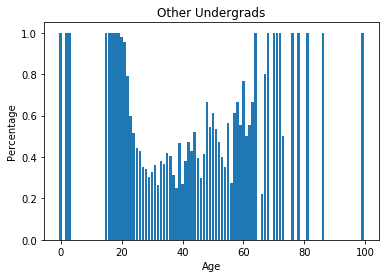

In [17]:
ages = set(SMTO_df['Age'])
percent_list = []
for i in ages:
    print("Percentage of " + str(i) + " year-olds in Other Undergrad: ", end='')
    age_percent = ((SMTO_df['Age'] == i) & (SMTO_df['Level'] == 'UG')).sum()/(SMTO_df['Age'] == i).sum()
    print(age_percent)
    percent_list.append(age_percent)

plt.bar(list(ages), percent_list)
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Other Undergrads')
plt.show()

Most respondents between the ages of 19 and 22 correspond to upper-year Undergraduate students. There are again many outliers at both ends of the age range.

Moving on to graduate students:

Percentage of 0 year-olds in GRAD: 0.0
Percentage of 2 year-olds in GRAD: 0.0
Percentage of 3 year-olds in GRAD: 0.0
Percentage of 4 year-olds in GRAD: 1.0
Percentage of 5 year-olds in GRAD: 1.0
Percentage of 15 year-olds in GRAD: 0.0
Percentage of 16 year-olds in GRAD: 0.0
Percentage of 17 year-olds in GRAD: 0.0
Percentage of 18 year-olds in GRAD: 0.002043944813490036
Percentage of 19 year-olds in GRAD: 0.0005685048322910744
Percentage of 20 year-olds in GRAD: 0.02005141388174807
Percentage of 21 year-olds in GRAD: 0.0447680690399137
Percentage of 22 year-olds in GRAD: 0.20864381520119224
Percentage of 23 year-olds in GRAD: 0.40303358613217766
Percentage of 24 year-olds in GRAD: 0.4843962008141113
Percentage of 25 year-olds in GRAD: 0.557427258805513
Percentage of 26 year-olds in GRAD: 0.5728542914171657
Percentage of 27 year-olds in GRAD: 0.6475409836065574
Percentage of 28 year-olds in GRAD: 0.6574923547400612
Percentage of 29 year-olds in GRAD: 0.6958174904942965
Percentage of 30 y

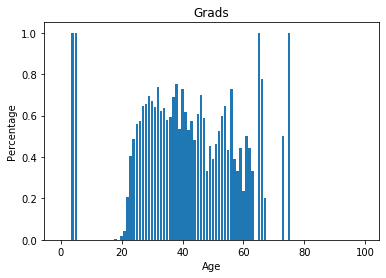

In [18]:
ages = set(SMTO_df['Age'])
percent_list = []
for i in ages:
    print("Percentage of " + str(i) + " year-olds in GRAD: ", end='')
    age_percent = ((SMTO_df['Age'] == i) & (SMTO_df['Level'] == 'Grad')).sum()/(SMTO_df['Age'] == i).sum()
    print(age_percent)
    percent_list.append(age_percent)

plt.bar(list(ages),percent_list)
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.title('Grads')
plt.show()

Around the age of 27 years, most respondents begin to identify as Graduate students.

Finally, let us look at those students whose status was 'Other':

The percentage of repondents who claim to be studying "Other" forms of education is very evenly distributed among the age range. Maybe a little lower around the 17-25 years.

## Segmentation Methods

There are several options we can consider to segment the TTS data:

1. Apply rules to TTS data based on SMTO data. For instance, all students who live with children under 18 are said to be living with their family.
2. Randomly assigning segments to TTS data based on a weighted probability distribution of similar students from the SMTO data.
3. Some combination of 1 and 2.
4. Change the segmentation approach so that the information is implictly available (e.g. replace "living with family" segments with "living with 1+ children or 2+ adults")
5. Use a machine learning approach such as clustering on the samples and compare results to establish a common segmentation approach.

Upon discussing these options, we decided to use a machine learning algorthm to classify students from the TTS data according to living arrangement. That is our next step.